# PROJET 3 : CONCEVEZ UNE APPLICATION DE SANTÉ PUBLIQUE (ANALYSE EXPLORATOIRE)

## 0 - PRÉALABLES :

### A - Gestion des avertissements :

In [1]:
# Suppression des avertissements :
import warnings
warnings.filterwarnings("ignore")

### B - Importation des librairies :

In [2]:
# Importation des librairies :
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.formula.api as smf
import statsmodels.api as sm
from scipy.stats import t, shapiro, kstest
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from sklearn import preprocessing, decomposition
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

### C - Importation du fichier :

In [3]:
# Importation du fichier :
data = pd.read_csv("data_fr_clean.csv")

## I - TRAITEMENT COMPLÉMENTAIRE DU FICHIER :

### A - Projet d'application :

### B - Adaptation du jeu de données au projet

#### 1) Choix des variables :

In [4]:
# Restriction aux variables utiles au projet :
heartcare = data[["code_barres","nom_produit","groupes_produits_1","groupes_produits_2","url_image","url_image_miniature","energie_100g","graisse_100g","graisse_saturee_100g","sel_100g","fibres_100g","nutriscore","indice_nutrition_uk_100g"]]

In [5]:
# Typage de la variable "Code_barres" en objet :
heartcare["code_barres"] = heartcare["code_barres"].astype(str)

In [6]:
# Majuscules au Nutriscore :
heartcare["nutriscore"] = heartcare["nutriscore"].str.upper()

In [7]:
# Imputation des valeurs numériques manquantes, par groupes de produits :
heartcare.fillna(heartcare.groupby("groupes_produits_2").transform("median"),inplace=True)

In [8]:
# Valeurs encore manquantes par colonnes.
heartcare.isnull().sum()

code_barres                     0
nom_produit                   340
groupes_produits_1          24366
groupes_produits_2          22827
url_image                   29239
url_image_miniature         29239
energie_100g                 1560
graisse_100g                15883
graisse_saturee_100g         1893
sel_100g                     1841
fibres_100g                  4058
nutriscore                  12483
indice_nutrition_uk_100g     2140
dtype: int64

In [9]:
# Imputation des valeurs numériques manquantes, par Graisse_saturée :
heartcare.fillna(heartcare.groupby("graisse_saturee_100g").transform("median"),inplace=True)

In [10]:
# Valeurs encore manquantes par colonnes.
heartcare.isna().sum()

code_barres                     0
nom_produit                   340
groupes_produits_1          24366
groupes_produits_2          22827
url_image                   29239
url_image_miniature         29239
energie_100g                 1545
graisse_100g                 1742
graisse_saturee_100g         1893
sel_100g                     1786
fibres_100g                  1852
nutriscore                  12483
indice_nutrition_uk_100g     1875
dtype: int64

In [11]:
# Création d'un indice de mauvaises graisses avec imputation par regroupement Nutriscore :
heartcare["indice_mauvaises_graisses"] = heartcare["graisse_saturee_100g"].replace(0,np.NaN)/heartcare["graisse_100g"].replace(0,np.NaN)
heartcare["indice_mauvaises_graisses"] = heartcare["indice_mauvaises_graisses"][heartcare["indice_mauvaises_graisses"]<100]
heartcare.fillna(heartcare.groupby("nutriscore").transform("median"),inplace=True)

In [12]:
# Nombre de valeurs manquante après une autre itération de fillna destinée à la nouvelle variable :
heartcare.isna().sum()

code_barres                      0
nom_produit                    340
groupes_produits_1           24366
groupes_produits_2           22827
url_image                    29239
url_image_miniature          29239
energie_100g                  1526
graisse_100g                  1539
graisse_saturee_100g          1874
sel_100g                      1767
fibres_100g                   1811
nutriscore                   12483
indice_nutrition_uk_100g      1875
indice_mauvaises_graisses     4871
dtype: int64

In [13]:
# Création d'un indice de saturation avec imputation par regroupement Nutriscore :
heartcare["indice_saturation"] = heartcare["graisse_saturee_100g"]/heartcare["energie_100g"].replace(0,np.NaN)
heartcare["indice_saturation"] = heartcare["indice_saturation"][heartcare["indice_saturation"]<1]
heartcare.fillna(heartcare.groupby("nutriscore").transform("median"),inplace=True)

In [14]:
heartcare.isna().sum()

code_barres                      0
nom_produit                    340
groupes_produits_1           24366
groupes_produits_2           22827
url_image                    29239
url_image_miniature          29239
energie_100g                  1526
graisse_100g                  1539
graisse_saturee_100g          1874
sel_100g                      1767
fibres_100g                   1811
nutriscore                   12483
indice_nutrition_uk_100g      1875
indice_mauvaises_graisses     4871
indice_saturation             1886
dtype: int64

### A - Vue globale du jeu de données :

#### 1) Tendances Centrales :

In [15]:
# Describe :
heartcare.describe()

,energie_100g,graisse_100g,graisse_saturee_100g,sel_100g,fibres_100g,indice_nutrition_uk_100g,indice_mauvaises_graisses,indice_saturation
count,71342.000000,71329.000000,70994.000000,71101.000000,71057.000000,70993.000000,67997.000000,70982.000000
mean,1074.373886,12.098011,5.114101,1.068452,2.045194,9.709478,0.418205,0.004075
std,789.052838,15.711515,8.172796,3.850829,3.694876,7.432376,0.992571,0.010487
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000011,0.000000
25%,385.000000,0.850000,0.200000,0.040000,0.000000,3.000000,0.200000,0.000372
50%,987.000000,5.900000,1.600000,0.530000,1.100000,8.000000,0.335294,0.002174
75%,1608.000000,19.000000,6.800000,1.210000,2.600000,15.000000,0.562500,0.005862
max,18700.000000,100.000000,100.000000,100.000000,100.000000,40.000000,93.700000,0.923529


#### 2) Matrice de corrélation :

In [16]:
# Matrice brute :
heartcare.corr()

,energie_100g,graisse_100g,graisse_saturee_100g,sel_100g,fibres_100g,indice_nutrition_uk_100g,indice_mauvaises_graisses,indice_saturation
energie_100g,1.000000,0.722123,0.570845,-0.009398,0.228842,0.641748,0.015540,0.087919
graisse_100g,0.722123,1.000000,0.750810,0.022680,0.046218,0.572946,-0.000624,0.256891
graisse_saturee_100g,0.570845,0.750810,1.000000,0.018505,0.015590,0.620935,0.117541,0.382097
sel_100g,-0.009398,0.022680,0.018505,1.000000,0.000819,0.097561,-0.008135,0.046731
fibres_100g,0.228842,0.046218,0.015590,0.000819,1.000000,-0.016139,-0.029922,-0.016412
indice_nutrition_uk_100g,0.641748,0.572946,0.620935,0.097561,-0.016139,1.000000,0.103055,0.203028
indice_mauvaises_graisses,0.015540,-0.000624,0.117541,-0.008135,-0.029922,0.103055,1.000000,0.103164
indice_saturation,0.087919,0.256891,0.382097,0.046731,-0.016412,0.203028,0.103164,1.000000


<AxesSubplot:>

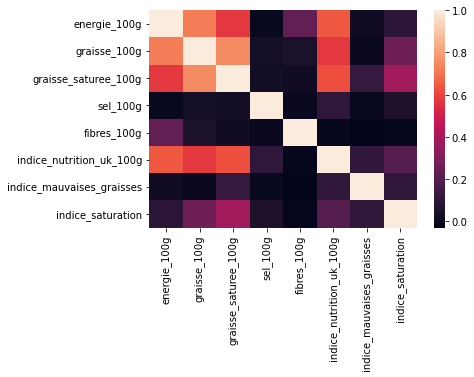

In [17]:
# Matrice heatmap :
sns.heatmap(heartcare.corr())

#### 3) Pairplot :

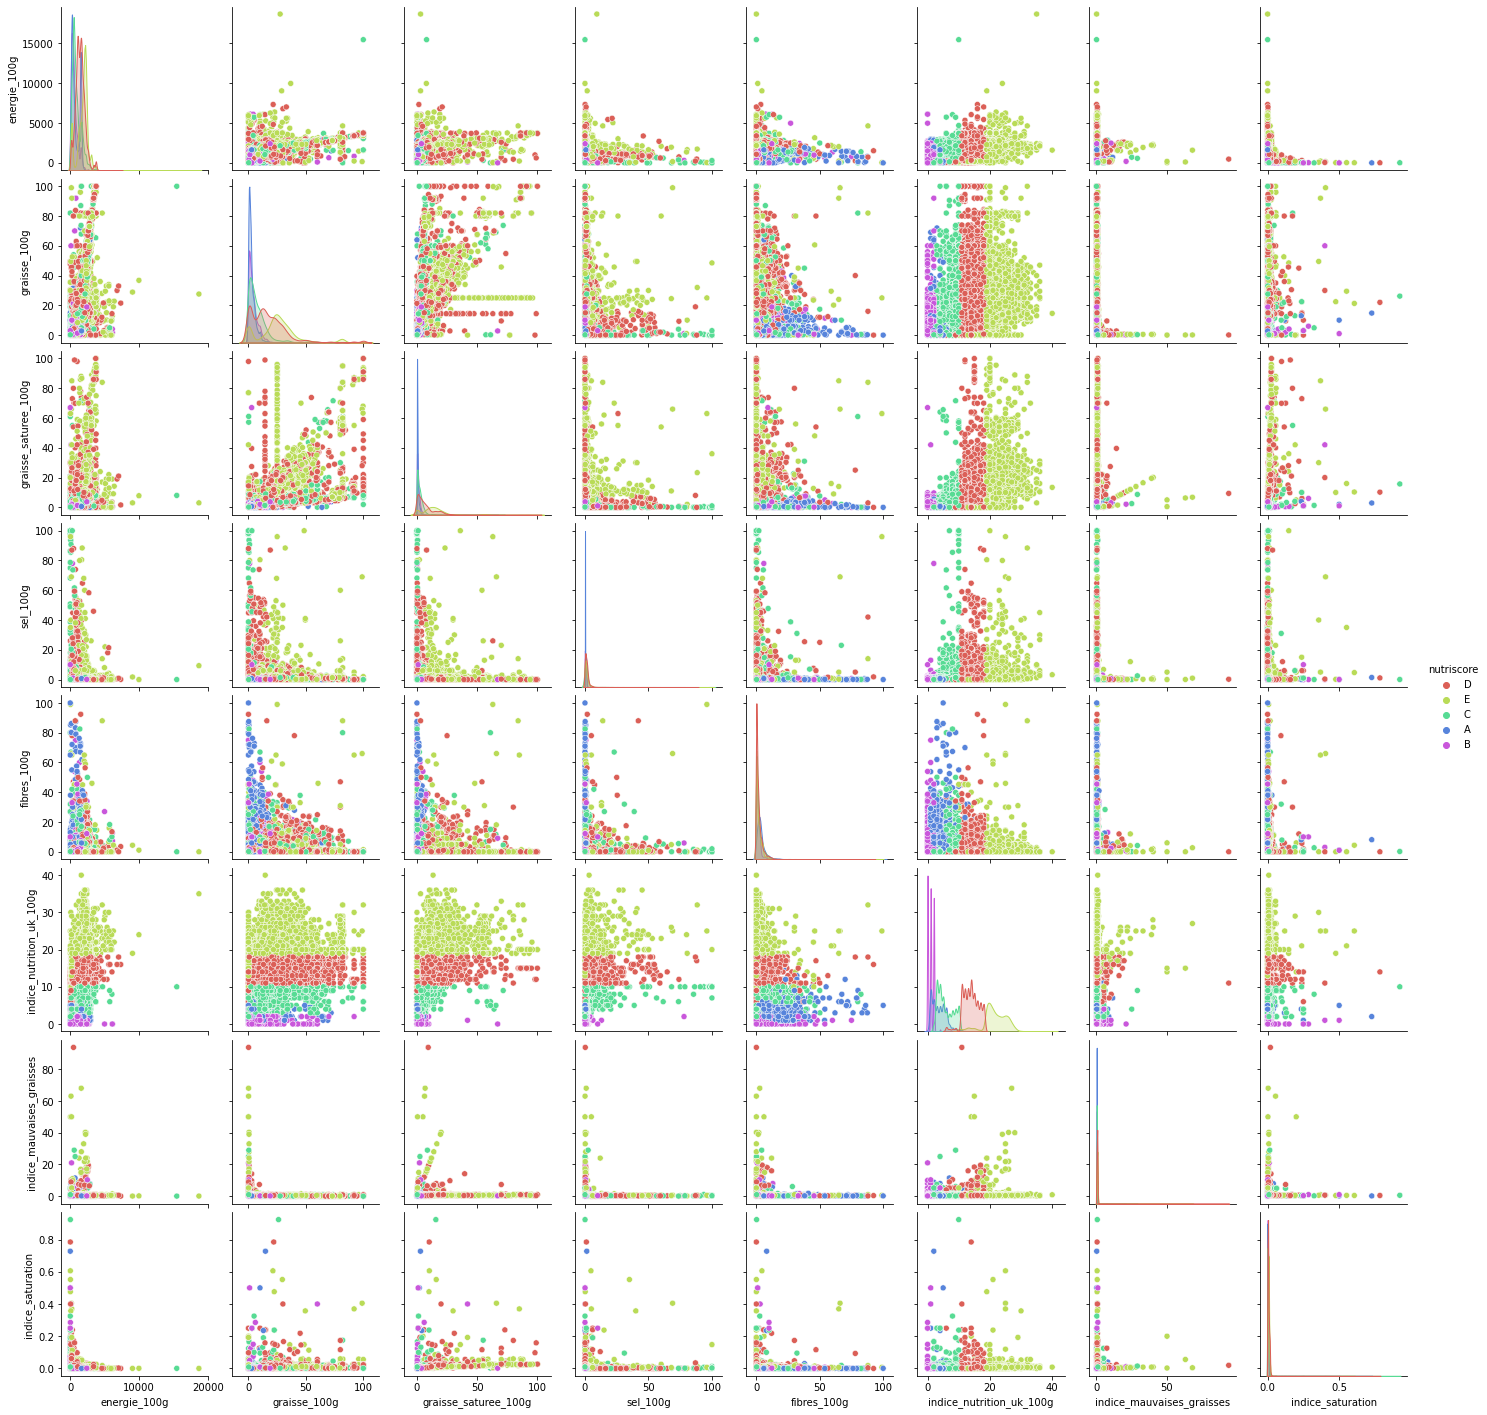

In [18]:
# Pairplot
sns.pairplot(heartcare, hue="nutriscore", palette="hls")

###  B - Distribution des variables :

#### 1) Graisse/100g :

Text(0, 0.5, 'Nombre de produits')

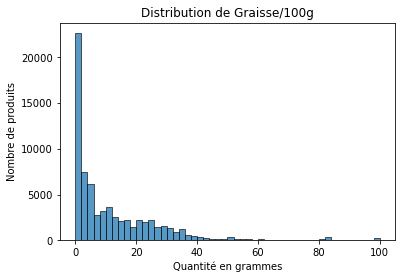

In [19]:
#  Histogramme :
plt.figure()
sns.histplot(heartcare["graisse_100g"].values, bins=50)
plt.title("Distribution de Graisse/100g")
plt.xlabel("Quantité en grammes")
plt.ylabel("Nombre de produits")

#### 2) Graisse saturée/100g :

Text(0, 0.5, 'Nombre de produits')

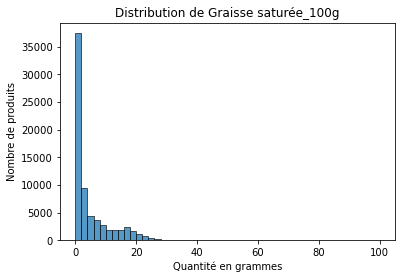

In [20]:
# Histogramme :
plt.figure()
sns.histplot(heartcare["graisse_saturee_100g"],bins=50)
plt.title("Distribution de Graisse saturée_100g")
plt.xlabel("Quantité en grammes")
plt.ylabel("Nombre de produits")

#### 4) Sel :

Text(0, 0.5, 'Nombre de produits')

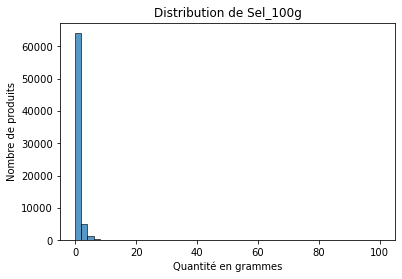

In [21]:
# Histogramme :
plt.figure()
sns.histplot(heartcare["sel_100g"],bins=50)
plt.title("Distribution de Sel_100g")
plt.xlabel("Quantité en grammes")
plt.ylabel("Nombre de produits")

Text(0, 0.5, 'Nombre de produits')

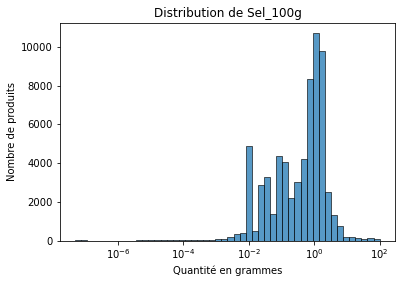

In [22]:
# Histogramme (log):
plt.figure()
sns.histplot(heartcare["sel_100g"][heartcare["sel_100g"].values>0],bins=50, log_scale=True)
plt.title("Distribution de Sel_100g")
plt.xlabel("Quantité en grammes")
plt.ylabel("Nombre de produits")

#### 5) Fibres :

Text(0, 0.5, 'Nombre de produits')

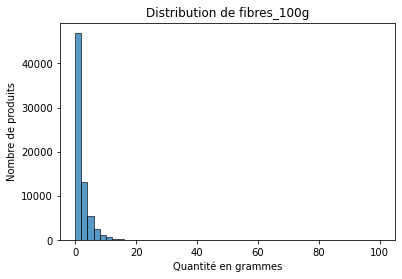

In [23]:
# Histogramme :
plt.figure()
sns.histplot(heartcare["fibres_100g"],bins=50)
plt.title("Distribution de fibres_100g")
plt.xlabel("Quantité en grammes")
plt.ylabel("Nombre de produits")

#### 6) Indice mauvaises graisses :

Text(0, 0.5, 'Nombre de produits')

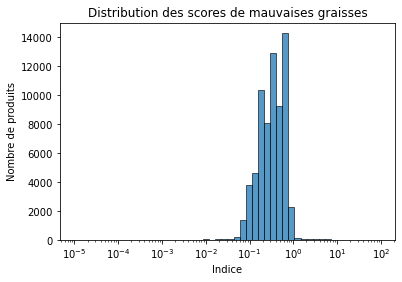

In [24]:
# Histogramme (log):
plt.figure()
sns.histplot(heartcare["indice_mauvaises_graisses"][heartcare["indice_mauvaises_graisses"].values>0],bins=50, log_scale=True)
plt.title("Distribution des scores de mauvaises graisses")
plt.xlabel("Indice")
plt.ylabel("Nombre de produits")

#### 7) Indice saturation :

Text(0, 0.5, 'Nombre de produits')

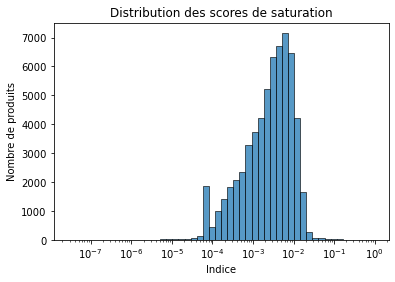

In [25]:
# Histogramme (log):
plt.figure()
sns.histplot(heartcare["indice_saturation"][heartcare["indice_saturation"].values>0],bins=50, log_scale=True)
plt.title("Distribution des scores de saturation")
plt.xlabel("Indice")
plt.ylabel("Nombre de produits")

#### 5) Nutriscore :

Text(0, 0.5, 'Quantité de produits')

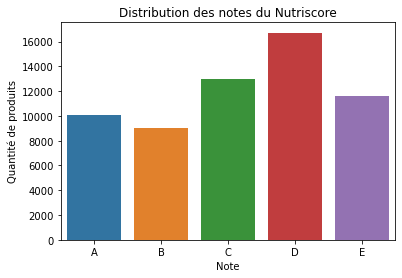

In [26]:
# Barplot :
nutriBar = heartcare["nutriscore"].value_counts()
plt.figure()
sns.barplot(x=nutriBar.index, y=nutriBar.values, order=["A","B","C","D","E"])
plt.title("Distribution des notes du Nutriscore")
plt.xlabel("Note")
plt.ylabel("Quantité de produits")

#### 6) Variable : Indice_nutrition_UK :

Text(0, 0.5, 'Nombre de produits')

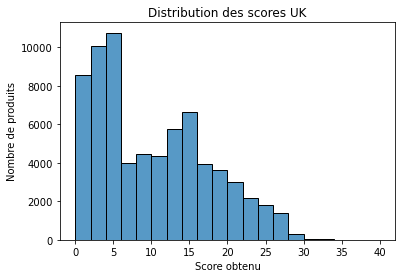

In [27]:
# Histogramme :
plt.figure()
sns.histplot(heartcare["indice_nutrition_uk_100g"],bins=20)
plt.title("Distribution des scores UK")
plt.xlabel("Score obtenu")
plt.ylabel("Nombre de produits")

## II - Analyses bivariées :

#### 1) Distribution des variables par groupes de produits  :

Text(0, 0.5, 'Groupe de produits')

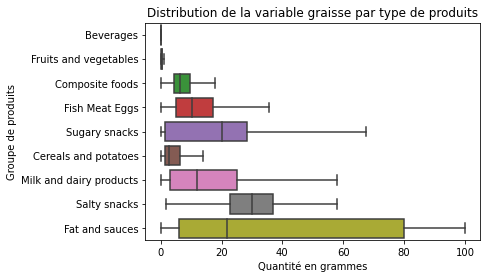

In [28]:
# Boxplot graisse :
plt.figure()
sns.boxplot(heartcare["graisse_100g"],heartcare["groupes_produits_1"],showfliers=False)
plt.title("Distribution de la variable graisse par type de produits")
plt.xlabel("Quantité en grammes")
plt.ylabel("Groupe de produits")

Text(0, 0.5, 'Groupe de produits')

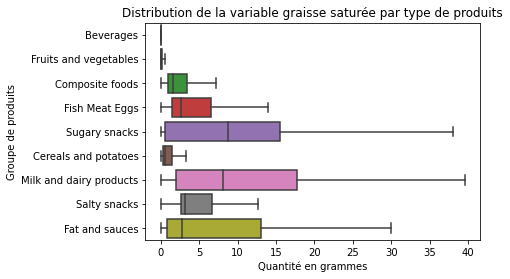

In [29]:
# Boxplot graisse saturée :
plt.figure()
sns.boxplot(heartcare["graisse_saturee_100g"],heartcare["groupes_produits_1"],showfliers=False)
plt.title("Distribution de la variable graisse saturée par type de produits")
plt.xlabel("Quantité en grammes")
plt.ylabel("Groupe de produits")

Text(0, 0.5, 'Groupe de produits')

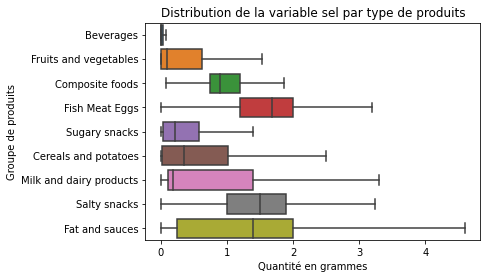

In [30]:
# Boxplot sel :
plt.figure()
sns.boxplot(heartcare["sel_100g"],heartcare["groupes_produits_1"],showfliers=False)
plt.title("Distribution de la variable sel par type de produits")
plt.xlabel("Quantité en grammes")
plt.ylabel("Groupe de produits")

Text(0, 0.5, 'Groupe de produits')

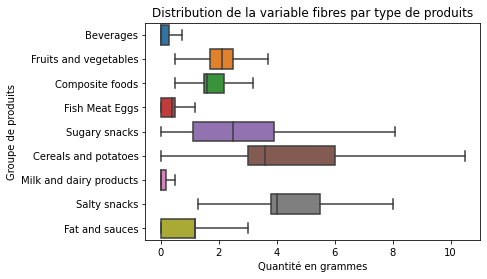

In [31]:
# Boxplot fibres :
plt.figure()
sns.boxplot(heartcare["fibres_100g"],heartcare["groupes_produits_1"],showfliers=False)
plt.title("Distribution de la variable fibres par type de produits")
plt.xlabel("Quantité en grammes")
plt.ylabel("Groupe de produits")

Text(0, 0.5, 'Groupe de produits')

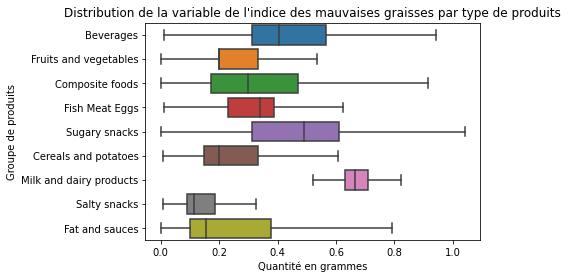

In [32]:
# Boxplot indice des mauvaises graisses :
plt.figure()
sns.boxplot(heartcare["indice_mauvaises_graisses"],heartcare["groupes_produits_1"],showfliers=False)
plt.title("Distribution de la variable de l'indice des mauvaises graisses par type de produits")
plt.xlabel("Quantité en grammes")
plt.ylabel("Groupe de produits")

Text(0, 0.5, 'Groupe de produits')

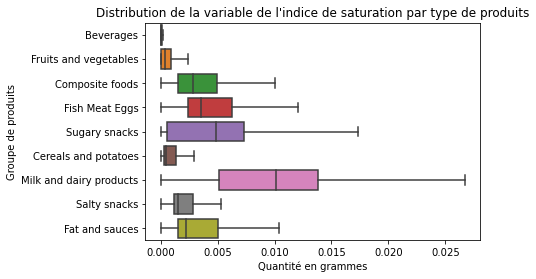

In [33]:
# Boxplot indice de saturation :
plt.figure()
sns.boxplot(heartcare["indice_saturation"],heartcare["groupes_produits_1"],showfliers=False)
plt.title("Distribution de la variable de l'indice de saturation par type de produits")
plt.xlabel("Quantité en grammes")
plt.ylabel("Groupe de produits")

#### 2) Distribution des variables par nutriscore :

Text(0, 0.5, 'Nutriscore')

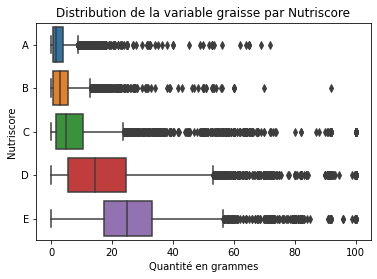

In [34]:
# Boxplot graisse :
plt.figure()
sns.boxplot(x=heartcare["graisse_100g"],y=heartcare["nutriscore"],order=["A","B","C","D","E"])
plt.title("Distribution de la variable graisse par Nutriscore")
plt.xlabel("Quantité en grammes")
plt.ylabel("Nutriscore")

Text(0, 0.5, 'Nutriscore')

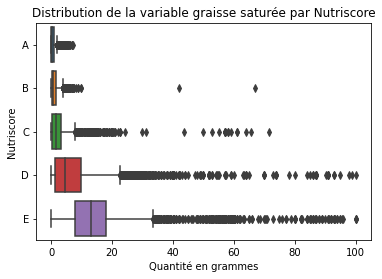

In [35]:
# Boxplot graisse saturée :
plt.figure()
sns.boxplot(x=heartcare["graisse_saturee_100g"],y=heartcare["nutriscore"],order=["A","B","C","D","E"])
plt.title("Distribution de la variable graisse saturée par Nutriscore")
plt.xlabel("Quantité en grammes")
plt.ylabel("Nutriscore")

Text(0, 0.5, 'Nutriscore')

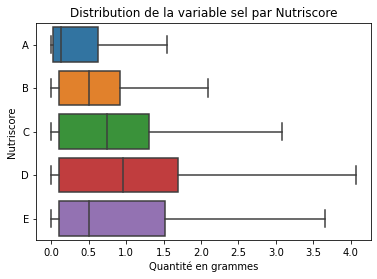

In [36]:
# Boxplot sel :
plt.figure()
sns.boxplot(x=heartcare["sel_100g"],y=heartcare["nutriscore"],order=["A","B","C","D","E"],showfliers=False)
plt.title("Distribution de la variable sel par Nutriscore")
plt.xlabel("Quantité en grammes")
plt.ylabel("Nutriscore")

Text(0, 0.5, 'Nutriscore')

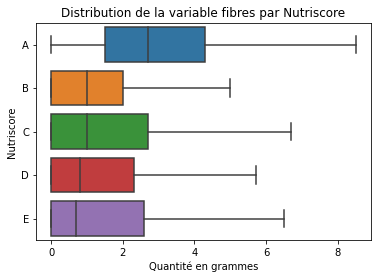

In [37]:
# Boxplot fibres :
plt.figure()
sns.boxplot(x=heartcare["fibres_100g"],y=heartcare["nutriscore"],order=["A","B","C","D","E"],showfliers=False)
plt.title("Distribution de la variable fibres par Nutriscore")
plt.xlabel("Quantité en grammes")
plt.ylabel("Nutriscore")

Text(0, 0.5, 'Nutriscore')

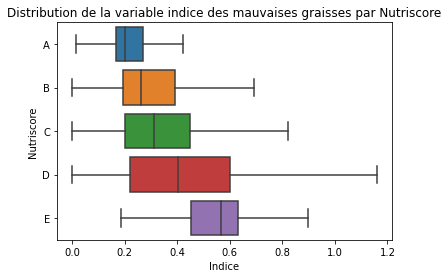

In [38]:
# Boxplot indice des mauvaises graisses :
plt.figure()
sns.boxplot(x=heartcare["indice_mauvaises_graisses"],y=heartcare["nutriscore"],order=["A","B","C","D","E"],showfliers=False)
plt.title("Distribution de la variable indice des mauvaises graisses par Nutriscore")
plt.xlabel("Indice")
plt.ylabel("Nutriscore")

Text(0, 0.5, 'Nutriscore')

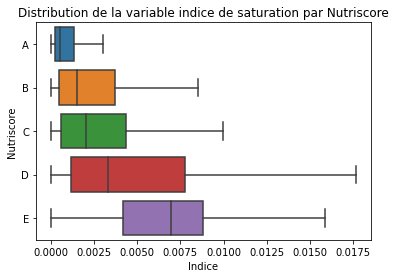

In [39]:
# Boxplot indice de saturation nutritionnelle :
plt.figure()
sns.boxplot(x=heartcare["indice_saturation"],y=heartcare["nutriscore"],order=["A","B","C","D","E"],showfliers=False)
plt.title("Distribution de la variable indice de saturation par Nutriscore")
plt.xlabel("Indice")
plt.ylabel("Nutriscore")

#### 3 - Corrélation des variables avec les scores UK et le nutriscore :

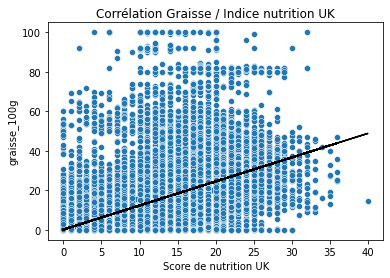

In [40]:
# Scatterplot Graisse - Indice UK :
plt.figure()
sns.scatterplot(x=heartcare["indice_nutrition_uk_100g"],y=heartcare["graisse_100g"])
plt.title("Corrélation Graisse / Indice nutrition UK")
plt.xlabel("Score de nutrition UK")
plt.ylabel("graisse_100g")

# Régression linéaire :
m, b = np.polyfit(heartcare["indice_nutrition_uk_100g"].fillna(heartcare["indice_nutrition_uk_100g"].median()),heartcare["graisse_100g"].fillna(heartcare["graisse_100g"].median()),1)
plt.plot(heartcare["indice_nutrition_uk_100g"], m * heartcare["indice_nutrition_uk_100g"] + b, '-k')

In [41]:
# Corrélation Graisse - Indice UK (Pearson) :
stats.pearsonr(heartcare["indice_nutrition_uk_100g"].fillna(heartcare["indice_nutrition_uk_100g"].median()), heartcare["graisse_100g"].fillna(heartcare["graisse_100g"].median()))

(0.5727921767449187, 0.0)

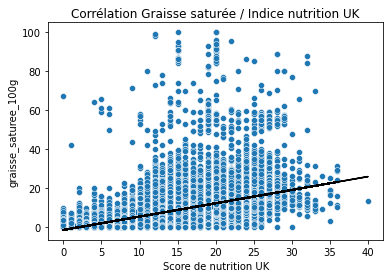

In [42]:
# Scatterplot Graisse saturée - Indice UK :
plt.figure()
sns.scatterplot(x=heartcare["indice_nutrition_uk_100g"],y=heartcare["graisse_saturee_100g"])
plt.title("Corrélation Graisse saturée / Indice nutrition UK")
plt.xlabel("Score de nutrition UK")
plt.ylabel("graisse_saturee_100g")

# Régression linéaire :
m, b = np.polyfit(heartcare["indice_nutrition_uk_100g"].fillna(heartcare["indice_nutrition_uk_100g"].median()),heartcare["graisse_saturee_100g"].fillna(heartcare["graisse_saturee_100g"].median()),1)
plt.plot(heartcare["indice_nutrition_uk_100g"], m * heartcare["indice_nutrition_uk_100g"] + b, '-k')

In [43]:
# Corrélation Graisse saturée - Indice UK (Pearson) :
stats.pearsonr(heartcare["indice_nutrition_uk_100g"].fillna(heartcare["indice_nutrition_uk_100g"].median()), heartcare["graisse_saturee_100g"].fillna(heartcare["graisse_saturee_100g"].median()))

(0.621579428240102, 0.0)

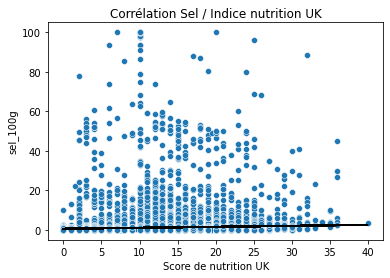

In [44]:
# Scatterplot Sel - Indice UK :
plt.figure()
sns.scatterplot(x=heartcare["indice_nutrition_uk_100g"],y=heartcare["sel_100g"])
plt.title("Corrélation Sel / Indice nutrition UK")
plt.xlabel("Score de nutrition UK")
plt.ylabel("sel_100g")

# Régression linéaire :
m, b = np.polyfit(heartcare["indice_nutrition_uk_100g"].fillna(heartcare["indice_nutrition_uk_100g"].median()),heartcare["sel_100g"].fillna(heartcare["sel_100g"].median()),1)
plt.plot(heartcare["indice_nutrition_uk_100g"], m * heartcare["indice_nutrition_uk_100g"] + b, '-k')

In [45]:
# Corrélation Sel - Indice UK (Pearson) :
stats.pearsonr(heartcare["indice_nutrition_uk_100g"].fillna(heartcare["indice_nutrition_uk_100g"].median()), heartcare["sel_100g"].fillna(heartcare["sel_100g"].median()))

(0.09486586146969482, 2.83037289308258e-145)

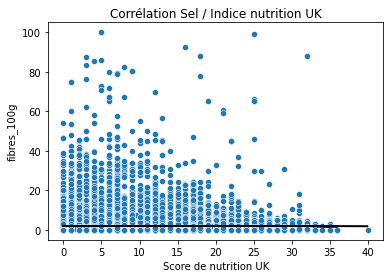

In [46]:
# Scatterplot Fibres - Indice UK :
plt.figure()
sns.scatterplot(x=heartcare["indice_nutrition_uk_100g"],y=heartcare["fibres_100g"])
plt.title("Corrélation Sel / Indice nutrition UK")
plt.xlabel("Score de nutrition UK")
plt.ylabel("fibres_100g")

# Régression linéaire :
m, b = np.polyfit(heartcare["indice_nutrition_uk_100g"].fillna(heartcare["indice_nutrition_uk_100g"].median()),heartcare["fibres_100g"].fillna(heartcare["fibres_100g"].median()),1)
plt.plot(heartcare["indice_nutrition_uk_100g"], m * heartcare["indice_nutrition_uk_100g"] + b, '-k')

In [47]:
# Corrélation fibres - Indice UK (Pearson) :
stats.pearsonr(heartcare["indice_nutrition_uk_100g"].fillna(heartcare["indice_nutrition_uk_100g"].median()), heartcare["fibres_100g"].fillna(heartcare["fibres_100g"].median()))

(-0.014797264612770917, 6.482144784303873e-05)

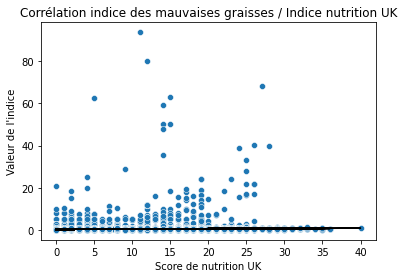

In [48]:
# Scatterplot Indice des mauvaises graisses - Indice UK :
plt.figure()
sns.scatterplot(x=heartcare["indice_nutrition_uk_100g"],y=heartcare["indice_mauvaises_graisses"])
plt.title("Corrélation indice des mauvaises graisses / Indice nutrition UK")
plt.xlabel("Score de nutrition UK")
plt.ylabel("Valeur de l'indice")

# Régression linéaire :
m, b = np.polyfit(heartcare["indice_nutrition_uk_100g"].fillna(heartcare["indice_nutrition_uk_100g"].median()),heartcare["indice_mauvaises_graisses"].fillna(heartcare["indice_mauvaises_graisses"].median()),1)
plt.plot(heartcare["indice_nutrition_uk_100g"], m * heartcare["indice_nutrition_uk_100g"] + b, '-k')

In [49]:
# Corrélation Indice mauvaises graisses - Indice UK (Pearson) :
stats.pearsonr(heartcare["indice_nutrition_uk_100g"].fillna(heartcare["indice_nutrition_uk_100g"].median()), heartcare["indice_mauvaises_graisses"].fillna(heartcare["indice_mauvaises_graisses"].median()))

(0.10415538270478991, 7.329115588931766e-175)

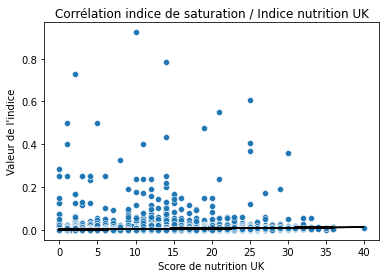

In [50]:
# Scatterplot Indice de saturation - Indice UK :
plt.figure()
sns.scatterplot(x=heartcare["indice_nutrition_uk_100g"],y=heartcare["indice_saturation"])
plt.title("Corrélation indice de saturation / Indice nutrition UK")
plt.xlabel("Score de nutrition UK")
plt.ylabel("Valeur de l'indice")

# Régression linéaire :
m, b = np.polyfit(heartcare["indice_nutrition_uk_100g"].fillna(heartcare["indice_nutrition_uk_100g"].median()),heartcare["indice_saturation"].fillna(heartcare["indice_saturation"].median()),1)
plt.plot(heartcare["indice_nutrition_uk_100g"], m * heartcare["indice_nutrition_uk_100g"] + b, '-k')

In [51]:
# Corrélation Indice saturation - Indice UK (Pearson) :
stats.pearsonr(heartcare["indice_nutrition_uk_100g"].fillna(heartcare["indice_nutrition_uk_100g"].median()), heartcare["indice_saturation"].fillna(heartcare["indice_saturation"].median()))

(0.2038863868045904, 0.0)

#### 4) Corrélation des variables avec le nutriscore :

In [52]:
# ANOVA Nutriscore - Graisse :
nutriscore_graisse = smf.ols("graisse_100g ~ nutriscore", data=heartcare).fit()
nutriscore_graisse.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           graisse_100g   R-squared:                       0.284
Model:                            OLS   Adj. R-squared:                  0.284
Method:                 Least Squares   F-statistic:                     5999.
Date:                Sat, 23 Apr 2022   Prob (F-statistic):               0.00
Time:                        14:29:56   Log-Likelihood:            -2.4228e+05
No. Observations:               60385   AIC:                         4.846e+05
Df Residuals:                   60380   BIC:                         4.846e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           2.8003      0.133     21.006      0.000       2.539       3.062
nutriscore[T.B]     1.2614      0.194      6.506      0.000       0.881       1.641
nutriscore[T.C]     5.5546      0.178     31.265      0.000       5.206       5.903
nutriscore[T.D]    14.7716      0.169     87.535      0.000      14.441      15.102
nutriscore[T.E]    22.9973      0.182    126.239      0.000      22.640      23.354
==============================================================================
Omnibus:                    32665.888   Durbin-Watson:                   1.217
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           359609.914
Skew:                           2.391   Prob(JB):                         0.00
Kurtosis:                      13.957   Cond. No.                         6.38
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [53]:
# Test de Fisher Nutriscore - Graisse :
sm.stats.anova_lm(nutriscore_graisse, typ=2)

,sum_sq,df,F,PR(>F)
nutriscore,4.292764e+06,4.0,5998.543805,0.0
Residual,1.080250e+07,60380.0,NaN,NaN


In [54]:
# ANOVA Nutriscore - Graisse saturée :
nutriscore_graisse_saturée = smf.ols("graisse_saturee_100g ~ nutriscore", data=heartcare).fit()
nutriscore_graisse_saturée.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     graisse_saturee_100g   R-squared:                       0.330
Model:                              OLS   Adj. R-squared:                  0.330
Method:                   Least Squares   F-statistic:                     7424.
Date:                  Sat, 23 Apr 2022   Prob (F-statistic):               0.00
Time:                          14:29:56   Log-Likelihood:            -2.0282e+05
No. Observations:                 60385   AIC:                         4.056e+05
Df Residuals:                     60380   BIC:                         4.057e+05
Df Model:                             4                                         
Covariance Type:              nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.5900      0.069      8.508      0.000       0.454       0.726
nutriscore[T.B]     0.5065      0.101      5.022      0.000       0.309       0.704
nutriscore[T.C]     1.7668      0.092     19.118      0.000       1.586       1.948
nutriscore[T.D]     6.5182      0.088     74.255      0.000       6.346       6.690
nutriscore[T.E]    13.4614      0.095    142.054      0.000      13.276      13.647
==============================================================================
Omnibus:                    51004.653   Durbin-Watson:                   1.275
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          2467820.810
Skew:                           3.814   Prob(JB):                         0.00
Kurtosis:                      33.375   Cond. No.                         6.38
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [55]:
# Test de Fisher Nutriscore - Graisse saturée :
sm.stats.anova_lm(nutriscore_graisse_saturée, typ=2)

,sum_sq,df,F,PR(>F)
nutriscore,1.437582e+06,4.0,7423.938411,0.0
Residual,2.923017e+06,60380.0,NaN,NaN


In [56]:
# ANOVA Nutriscore - Sel :
nutriscore_sel = smf.ols("sel_100g ~ nutriscore", data=heartcare).fit()
nutriscore_sel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               sel_100g   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     223.8
Date:                Sat, 23 Apr 2022   Prob (F-statistic):          5.18e-191
Time:                        14:29:56   Log-Likelihood:            -1.6368e+05
No. Observations:               60385   AIC:                         3.274e+05
Df Residuals:                   60380   BIC:                         3.274e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.3348      0.036      9.232      0.000       0.264       0.406
nutriscore[T.B]     0.2147      0.053      4.070      0.000       0.111       0.318
nutriscore[T.C]     0.9790      0.048     20.255      0.000       0.884       1.074
nutriscore[T.D]     1.1375      0.046     24.779      0.000       1.048       1.228
nutriscore[T.E]     0.9403      0.050     18.974      0.000       0.843       1.037
==============================================================================
Omnibus:                   127171.311   Durbin-Watson:                   1.214
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        469373873.484
Skew:                          18.533   Prob(JB):                         0.00
Kurtosis:                     433.324   Cond. No.                         6.38
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [57]:
# Test de Fisher Nutriscore - Sel :
sm.stats.anova_lm(nutriscore_sel, typ=2)

,sum_sq,df,F,PR(>F)
nutriscore,11851.485335,4.0,223.761961,5.184354e-191
Residual,799502.159492,60380.0,NaN,NaN


In [58]:
# ANOVA Nutriscore - Fibres :
nutriscore_fibres = smf.ols("fibres_100g ~ nutriscore", data=heartcare).fit()
nutriscore_fibres.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            fibres_100g   R-squared:                       0.044
Model:                            OLS   Adj. R-squared:                  0.044
Method:                 Least Squares   F-statistic:                     690.5
Date:                Sat, 23 Apr 2022   Prob (F-statistic):               0.00
Time:                        14:29:57   Log-Likelihood:            -1.6622e+05
No. Observations:               60385   AIC:                         3.324e+05
Df Residuals:                   60380   BIC:                         3.325e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           3.9510      0.038    104.453      0.000       3.877       4.025
nutriscore[T.B]    -2.3946      0.055    -43.529      0.000      -2.502      -2.287
nutriscore[T.C]    -1.8478      0.050    -36.655      0.000      -1.947      -1.749
nutriscore[T.D]    -2.1192      0.048    -44.259      0.000      -2.213      -2.025
nutriscore[T.E]    -2.2440      0.052    -43.413      0.000      -2.345      -2.143
==============================================================================
Omnibus:                    82553.012   Durbin-Watson:                   1.438
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         33380223.540
Skew:                           7.776   Prob(JB):                         0.00
Kurtosis:                     117.127   Cond. No.                         6.38
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [59]:
# Test de Fisher Nutriscore - Sel :
sm.stats.anova_lm(nutriscore_fibres, typ=2)

,sum_sq,df,F,PR(>F)
nutriscore,39784.806366,4.0,690.533347,0.0
Residual,869692.470347,60380.0,NaN,NaN


In [60]:
# ANOVA Nutriscore - Indice de mauvaises graisses :
nutriscore_indice_mauvaises_graisses = smf.ols("indice_mauvaises_graisses ~ nutriscore", data=heartcare).fit()
nutriscore_indice_mauvaises_graisses.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                OLS Regression Results                               
=====================================================================================
Dep. Variable:     indice_mauvaises_graisses   R-squared:                       0.018
Model:                                   OLS   Adj. R-squared:                  0.018
Method:                        Least Squares   F-statistic:                     279.0
Date:                       Sat, 23 Apr 2022   Prob (F-statistic):          3.82e-238
Time:                               14:29:57   Log-Likelihood:                -76415.
No. Observations:                      60385   AIC:                         1.528e+05
Df Residuals:                          60380   BIC:                         1.529e+05
Df Model:                                  4                                         
Covariance Type:                   nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.2645      0.009     30.933      0.000       0.248       0.281
nutriscore[T.B]     0.0664      0.012      5.343      0.000       0.042       0.091
nutriscore[T.C]     0.0988      0.011      8.673      0.000       0.076       0.121
nutriscore[T.D]     0.1816      0.011     16.784      0.000       0.160       0.203
nutriscore[T.E]     0.3536      0.012     30.265      0.000       0.331       0.376
==============================================================================
Omnibus:                   194955.826   Durbin-Watson:                   1.907
Prob(Omnibus):                  0.000   Jarque-Bera (JB):      43608856583.649
Skew:                          53.821   Prob(JB):                         0.00
Kurtosis:                    4164.819   Cond. No.                         6.38
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [61]:
# Test de Fisher Nutriscore - Mauvaises graisses :
sm.stats.anova_lm(nutriscore_indice_mauvaises_graisses, typ=2)

,sum_sq,df,F,PR(>F)
nutriscore,821.212879,4.0,279.038682,3.824256e-238
Residual,44424.695229,60380.0,NaN,NaN


In [62]:
# ANOVA Nutriscore - Indice de saturation :
nutriscore_indice_saturation = smf.ols("indice_saturation ~ nutriscore", data=heartcare).fit()
nutriscore_indice_saturation.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      indice_saturation   R-squared:                       0.035
Model:                            OLS   Adj. R-squared:                  0.035
Method:                 Least Squares   F-statistic:                     541.4
Date:                Sat, 23 Apr 2022   Prob (F-statistic):               0.00
Time:                        14:29:57   Log-Likelihood:             1.8777e+05
No. Observations:               60385   AIC:                        -3.755e+05
Df Residuals:                   60380   BIC:                        -3.755e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.0013      0.000     11.913      0.000       0.001       0.001
nutriscore[T.B]     0.0014      0.000      8.993      0.000       0.001       0.002
nutriscore[T.C]     0.0022      0.000     15.129      0.000       0.002       0.002
nutriscore[T.D]     0.0041      0.000     30.321      0.000       0.004       0.004
nutriscore[T.E]     0.0061      0.000     41.209      0.000       0.006       0.006
==============================================================================
Omnibus:                   174978.532   Durbin-Watson:                   1.889
Prob(Omnibus):                  0.000   Jarque-Bera (JB):      14109648807.989
Skew:                          39.958   Prob(JB):                         0.00
Kurtosis:                    2369.746   Cond. No.                         6.38
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [63]:
# Test de Fisher Nutriscore - Mauvaises graisses :
sm.stats.anova_lm(nutriscore_indice_saturation, typ=2)

,sum_sq,df,F,PR(>F)
nutriscore,0.252479,4.0,541.36748,0.0
Residual,7.039903,60380.0,NaN,NaN


#### 5) Nutriscore et l'indice nutritionnel britannique :

Text(0, 0.5, 'Nutriscore')

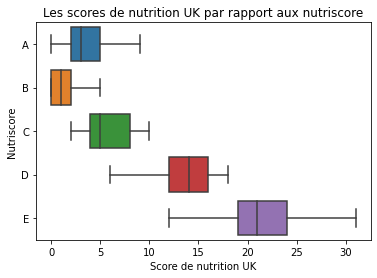

In [64]:
# Comparaison du nutriscore avec l'indice nutritionnel britannique :
plt.figure()
sns.boxplot(x=heartcare["indice_nutrition_uk_100g"],y=heartcare["nutriscore"],order=["A","B","C","D","E"],showfliers=False)
plt.title("Les scores de nutrition UK par rapport aux nutriscore")
plt.xlabel("Score de nutrition UK")
plt.ylabel("Nutriscore")

In [65]:
# ANOVA Nutriscore - indice nutritionnel britannique :
nutriscore_uk = smf.ols("indice_nutrition_uk_100g ~ nutriscore", data=heartcare).fit()
nutriscore_uk.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                               
====================================================================================
Dep. Variable:     indice_nutrition_uk_100g   R-squared:                       0.878
Model:                                  OLS   Adj. R-squared:                  0.878
Method:                       Least Squares   F-statistic:                 1.091e+05
Date:                      Sat, 23 Apr 2022   Prob (F-statistic):               0.00
Time:                              14:29:58   Log-Likelihood:            -1.4520e+05
No. Observations:                     60385   AIC:                         2.904e+05
Df Residuals:                         60380   BIC:                         2.905e+05
Df Model:                                 4                                         
Covariance Type:                  nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           3.6511      0.027    136.703      0.000       3.599       3.703
nutriscore[T.B]    -2.6769      0.039    -68.915      0.000      -2.753      -2.601
nutriscore[T.C]     2.0169      0.036     56.664      0.000       1.947       2.087
nutriscore[T.D]    10.1539      0.034    300.332      0.000      10.088      10.220
nutriscore[T.E]    17.7450      0.036    486.192      0.000      17.674      17.817
==============================================================================
Omnibus:                     3254.665   Durbin-Watson:                   1.445
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            10122.601
Skew:                          -0.235   Prob(JB):                         0.00
Kurtosis:                       4.950   Cond. No.                         6.38
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [66]:
# Test de Fisher Nutriscore - indice nutritionnel britannique :
sm.stats.anova_lm(nutriscore_uk, typ=2)

,sum_sq,df,F,PR(>F)
nutriscore,3.133330e+06,4.0,109079.613711,0.0
Residual,4.336063e+05,60380.0,NaN,NaN


## III - Analyse en composantes principales :

### A - Programmes préalables :

#### 1) Cercle des corrélations :

In [67]:
# Cercle des corrélations :
def display_circles(pcs, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None):
    for d1, d2 in axis_ranks: # On affiche les 3 premiers plans factoriels, donc les 6 premières composantes
        if d2 < n_comp:

            # initialisation de la figure
            fig, ax = plt.subplots(figsize=(7,6))

            # détermination des limites du graphique
            if lims is not None :
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30 :
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else :
                xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])

            # affichage des flèches
            # s'il y a plus de 30 flèches, on n'affiche pas le triangle à leur extrémité
            if pcs.shape[1] < 30 :
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                   pcs[d1,:], pcs[d2,:], 
                   angles='xy', scale_units='xy', scale=1, color="grey")
                # (voir la doc : https://matplotlib.org/api/_as_gen/matplotlib.pyplot.quiver.html)
            else:
                lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
                ax.add_collection(LineCollection(lines, axes=ax, alpha=.1, color='black'))
            
            # affichage des noms des variables  
            if labels is not None:  
                for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                        plt.text(x, y, labels[i], fontsize='14', ha='center', va='center', rotation=label_rotation, color="blue", alpha=0.5)
            
            # affichage du cercle
            circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
            plt.gca().add_artist(circle)

            # définition des limites du graphique
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)
        
            # affichage des lignes horizontales et verticales
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)
# Éboulis des valeurs propres :
def display_scree_plot(pca):
    scree = pca.explained_variance_ratio_*100
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
    plt.xlabel("rang de l'axe d'inertie")
    plt.ylabel("pourcentage d'inertie")
    plt.title("Eboulis des valeurs propres")
    plt.show(block=False)

#### 2) Éboulis des valeurs propres :

In [68]:
# Éboulis des valeurs propres :
def display_scree_plot(pca):
    scree = pca.explained_variance_ratio_*100
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
    plt.xlabel("rang de l'axe d'inertie")
    plt.ylabel("pourcentage d'inertie")
    plt.title("Eboulis des valeurs propres")
    plt.show(block=False)

### B - Préparation de l'ACP :

#### 1) Preprocessing :

In [69]:
# Dataframe d'exploration :
explo = heartcare.set_index("code_barres")
explo = explo[["graisse_100g","graisse_saturee_100g","sel_100g","fibres_100g","indice_mauvaises_graisses","indice_saturation"]].fillna(heartcare.median())

In [70]:
# Définitions :
X = explo.values

In [71]:
# Centrage et réduction :
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

#### 2) Éboulis des valeurs propres :

In [72]:
# Calcul des composantes principales :
n_comp = 6
pca = decomposition.PCA(n_components=n_comp)
pca.fit(X_scaled)

PCA(n_components=6)

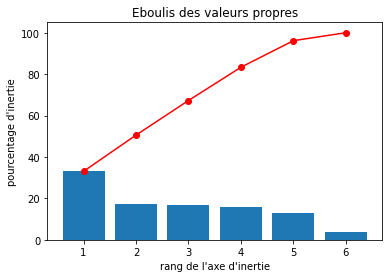

In [73]:
# Visualisation :
display_scree_plot(pca)

#### 3) Cercle des corrélations :

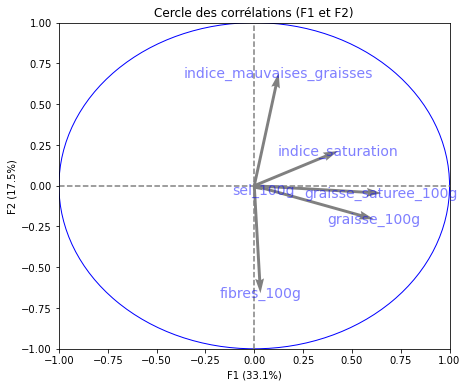

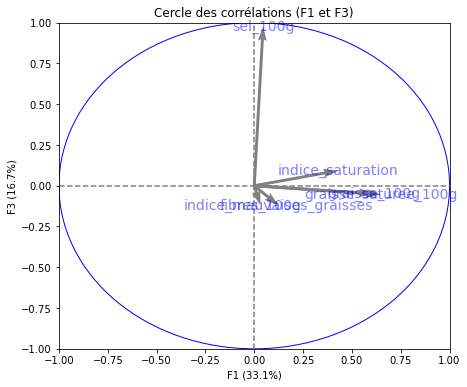

In [74]:
# Cercle des corrélations :
pcs = pca.components_
labelsVariables = explo.columns
display_circles(pcs, 3, pca,[(0,1),(0,2)],labels = np.array(labelsVariables))

### C - K-Means :

#### 1) Méthode du coude :

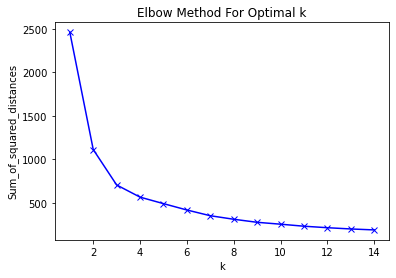

In [91]:
# Méthode du coude pour K-Means :
mms = MinMaxScaler()
mms.fit(X_scaled)
data_transformed = mms.transform(X_scaled)

Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(data_transformed)
    Sum_of_squared_distances.append(km.inertia_)
    
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

#### 2) Clustering par K-Means :

In [149]:
# K-Means :
n_clust = 3
km = KMeans(n_clusters=n_clust, random_state=42)
km.fit(X_scaled)
clusters = km.labels_

#### 3) Attribution des numéros de clusters :

In [150]:
# Attribution du numéro de cluster sur le dataframe principal :
heartcare["cluster"] = clusters

### D - Visualisation de l'ACP :

In [151]:
# Preprocessing :
pca = decomposition.PCA().fit(X_scaled)
Z_projected = pca.transform(X_scaled)

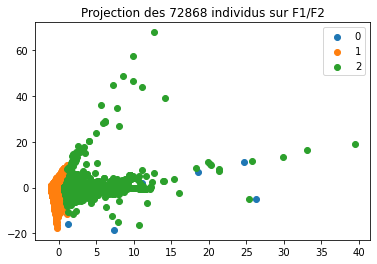

In [152]:
# Visualisation de la projection F1/F2 :
label = clusters
u_labels = np.unique(label)
for i in u_labels:
    plt.scatter(Z_projected[label == i , 0] , Z_projected[label == i , 1] , label = i)
plt.legend(loc="upper right")
plt.title("Projection des {} individus sur F1/F2".format(Z_projected.shape[0]))
plt.show(block=False)

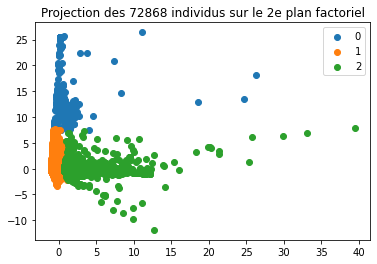

In [153]:
# Visualisation de la projection F1/F3 :
label = clusters
u_labels = np.unique(label)
for i in u_labels:
    plt.scatter(Z_projected[label == i , 0] , Z_projected[label == i , 2] , label = i)
plt.legend(loc="upper right")
plt.title("Projection des {} individus sur F1/F3".format(Z_projected.shape[0]))
plt.show(block=False)

### E - Caractérisation des clusters :

<function matplotlib.pyplot.show(close=None, block=None)>

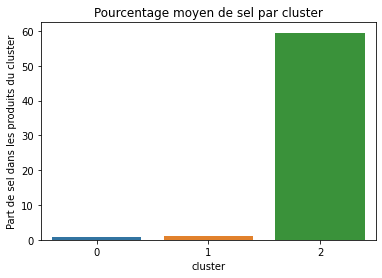

In [112]:
# Sel par cluster (barplot)
plt.figure()
sns.barplot(x=heartcare["cluster"], y=heartcare["sel_100g"], ci=None)
plt.title("Pourcentage moyen de sel par cluster")
plt.xlabel("cluster")
plt.ylabel("Part de sel dans les produits du cluster")
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

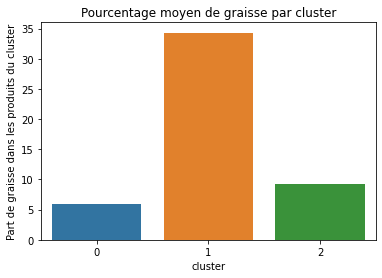

In [113]:
# Graisse par cluster (barplot)
plt.figure()
sns.barplot(x=heartcare["cluster"], y=heartcare["graisse_100g"], ci=None)
plt.title("Pourcentage moyen de graisse par cluster")
plt.xlabel("cluster")
plt.ylabel("Part de graisse dans les produits du cluster")
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

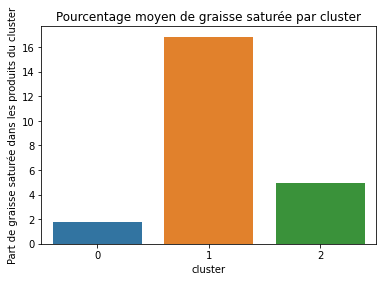

In [114]:
# Graisse saturée par cluster (barplot)
plt.figure()
sns.barplot(x=heartcare["cluster"], y=heartcare["graisse_saturee_100g"], ci=None)
plt.title("Pourcentage moyen de graisse saturée par cluster")
plt.xlabel("cluster")
plt.ylabel("Part de graisse saturée dans les produits du cluster")
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

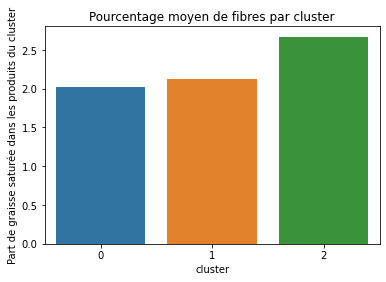

In [115]:
# Fibres par cluster (barplot)
plt.figure()
sns.barplot(x=heartcare["cluster"], y=heartcare["fibres_100g"], ci=None)
plt.title("Pourcentage moyen de fibres par cluster")
plt.xlabel("cluster")
plt.ylabel("Part de graisse saturée dans les produits du cluster")
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

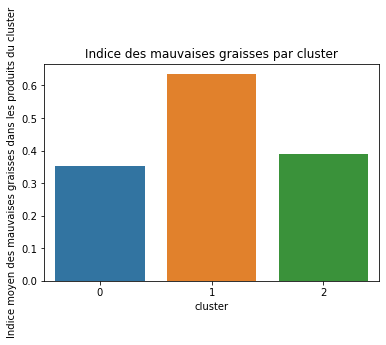

In [116]:
# Indice de mauvaises graisses par cluster (barplot)
plt.figure()
sns.barplot(x=heartcare["cluster"], y=heartcare["indice_mauvaises_graisses"], ci=None)
plt.title("Indice des mauvaises graisses par cluster")
plt.xlabel("cluster")
plt.ylabel("Indice moyen des mauvaises graisses dans les produits du cluster")
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

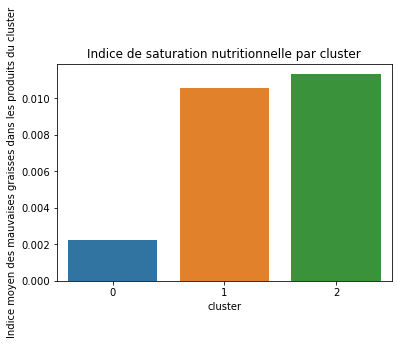

In [117]:
# Indice de saturation nutritionnelle cluster (barplot)
plt.figure()
sns.barplot(x=heartcare["cluster"], y=heartcare["indice_saturation"], ci=None)
plt.title("Indice de saturation nutritionnelle par cluster")
plt.xlabel("cluster")
plt.ylabel("Indice moyen des mauvaises graisses dans les produits du cluster")
plt.show

## IV - Test du modèle d'application :

### A - Definition :

In [144]:
def heartcare_app(code_barres) :

    # Restriction sur le produit scanné :
    prod = heartcare[heartcare["code_barres"]==str(code_barres)]
    
    # Récupération des informations du produit :
    nom_prod = prod["nom_produit"].values
    cluster = prod["cluster"].values
    nutriscore = prod["nutriscore"].values
    sel = prod["sel_100g"].values
    graisse_saturee = prod["graisse_saturee_100g"].values
    fibres = prod["fibres_100g"].values
    
    
    # Affichage du texte :
    print("Vous avez scanné :", nom_prod)
    
    if cluster == 0 :
        print("Heartcare recommande ce produit pour le bon fonctionnement de votre coeur !")
        
    elif cluster == 2 :
        print("Heartcare vous déconseille ce produit riche en sel, surtout si vous êtes hypertendu(e)")
        
    else :
        print("Heartcare vous déconseille ce produit riche en graisses, surtout si vous avez du cholesterol")

    print("En complément d'information, sachez que ce produit est classé", nutriscore, "sur l'échelle du Nutriscore")
    print("Il contient :" ,sel, "% de sel", graisse_saturee, "% de graisses saturées et", fibres, "% de fibres")

### B - Test avec des produits :

In [145]:
# Exemple produit classé 2 : 
heartcare_app(9421025231179)

Vous avez scanné : ['Capricare Lait De Chèvre 2 De 6 Mois à 1 an 400 G']
Heartcare vous déconseille ce produit riche en sel, surtout si vous êtes hypertendu(e)
En complément d'information, sachez que ce produit est classé ['E'] sur l'échelle du Nutriscore
Il contient : [45.] % de sel [10.4] % de graisses saturées et [0.] % de fibres


In [146]:
# Exemple produit classé 0 : 
heartcare_app(3033490327873)

Vous avez scanné : ['Taillefine recette au fromage blanc pêche']
Heartcare recommande ce produit pour le bon fonctionnement de votre coeur !
En complément d'information, sachez que ce produit est classé ['A'] sur l'échelle du Nutriscore
Il contient : [0.13] % de sel [0.06] % de graisses saturées et [0.3] % de fibres


In [147]:
# Exemple produit classé 1 : 
heartcare_app(1171969)

Vous avez scanné : ['Nutella']
Heartcare vous déconseille ce produit riche en graisses, surtout si vous avez du cholesterol
En complément d'information, sachez que ce produit est classé ['E'] sur l'échelle du Nutriscore
Il contient : [0.09398] % de sel [10.9] % de graisses saturées et [3.4] % de fibres
